In [8]:
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from astropy import constants as ct
from astropy import units as unit
from astropy.cosmology import WMAP9 as cosmo

# La expansión acelerada del Universo
### Modelado matemático II - Trabajo No. 1

**Profesor**: Juan Carlos Basto Pineda.

**Estudiante**: Juan Andrés Olmos Rojas.


Es conocido que el universo está en expansión y la ley de Hubble-Lemaitre fue clave para descubrirlo. Esta meciona que las galaxias se alejan a una velocidad ($v$) que es proporcional a su distancia ($d$): 

$$ v = H_0 \times d$$
donde $H_0$ se conoce como constante de Hubble.

In [9]:
#Constante de Hubble
H0 = cosmo.H(0)  
H0

<Quantity 69.32 km / (Mpc s)>

En el caso de las galaxias, distancia y velocidad deben ser inferidas a partir de otras cantidades. Por ejemplo **la distancia** se puede medir a partir del brillo aparente. Siendo $M$ la magnitud absoluta del verdadero objeto y $m$ la magnitud aparente en la tierra, se tiene que 
$$m - M = 5\log_{10} (D_L) + 25$$
donde $D_L$ se conoce como distancia de luminosidad. Para **la velocidad** sabemos que la longitud de onda que nos llega ($\lambda_{obs}$) es mayor a la realmente emitida ($\lambda_{em}$), esto se conoce como corrimiento al rojo de la luz ($z$)

$$z = \frac{\lambda_{obs} - \lambda_{em}}{\lambda_{em}}$$

comparado con la velocidad de la luz $c$, se puede obtener lo siguiente

$$z = \frac{v}{c}$$


In [10]:
# Velocidad de la luz
c = (ct.c).to(unit.km / unit.s)
c

<Quantity 299792.458 km / s>

Este corrimiento al rojo nos dice en que momento de la historia estamos observando una galaxia, por tanto, 
para un estudio de la expansión es interesante analizar la relación entre $z$ y $D_L$. Es aquí cuando aparecen las ecuaciones de Friedmann-Lemaitre para medir dicha relación según la cantidad de materia y energía existentes en el Universo

### Eq. 1
![](./imgs/formulaDL.png) 

Acá $\Omega_M$ y $\Omega_{\Lambda}$ son el porcentaje de energía por compuesto por materia y energía oscura respectivamente.

A continuación se presentan la función ``dl``(Eq. 1. )que a su vez depende de la función ``integral`` (Eq. 2.), la cual calcula el valor de $I$ para la anterior ecuación

### Eq. 2
![](./imgs/integral.png) 

In [19]:
def integral(z,om,oa,ok):
    """Calcula la integral relacionada con las ecuaciones de Friedmann-Lemaitre

    Args:
        z (float): Corrimiento al rojo
        om (float): Porcentaje de la energia compuesto por materia
        oa (float): Porcentaje de la energia compuesto por ENERGIA OSCURA
        ok (float): Curvatura del universo.

    Returns:
        resultado (float)
    """    
    # Se utiliza metodo de cuadratura 
    resultado = integrate.quad(lambda z: 1 / (np.sqrt(om * (1+z)**3 + oa + ok * (1 + z)**2)), 0, z)
    resultado = resultado[0]
    return resultado
    
def dl(z,
       om, 
       oa, 
       c= (ct.c).to(unit.km / unit.s), #apprx. en km/s
       ho = cosmo.H(0)  #Constante de Hubble
      ):   
    """Estimación de la distancia usando las ecuaciones de Friedmann-Lemaitre.

    Args:
        z (float): Corrimiento al rojo
        om (float): Porcentaje de la energia compuesto por materia
        oa (float): Porcentaje de la energia compuesto por ENERGIA OSCURA
        c (ASTROPY CTE): Velocidad de la luz. Defaults to km / s.
        ho (ASTROPY CTE): Constante de Hubble. Defaults to km / Mpc x s.
    Returns:
        dl (float): distancia estimada
    """       
    ok = 1-om-oa #curvatura del espacio
    if om + oa > 1:
        dl = (1 + z) * c/ ho
        dl = dl * (1 / np.sqrt(ok)) 
        I = integral(z,om,oa,ok)
        dl = dl * np.sin(np.sqrt(ok) * I)
    elif om + oa == 1:
        dl = (1 + z) * c/ ho
        I = integral(z,om,oa,ok)
        dl = dl * I
    elif om + oa < 1:  
        dl = (1 + z) * c/ ho
        dl = dl * (1 / np.sqrt(ok)) 
        I = integral(z,om,oa,ok)
        dl = dl * np.sinh(np.sqrt(ok) * I)
    dl = 5 * np.log10(dl.value) + 25     
    return dl

# Datos reales

Tomados de "Supernova cosmology project", contiene el nombre de la supernova (``name``), el corrimiento (``z``), la magnitud de la distancia (``dl_real``), error en la medición (``dl_real_error``) y una ultima medición que por ahora no es de interes en nuestro estudio (``d3``)

In [14]:
df = pd.read_csv('magnitudVSredshift.txt', delim_whitespace=True, header = None)
df.columns = ['name','z', 'dl_real', 'dl_real_error', 'd3']
df = df.sort_values('z')
df

,name,z,dl_real,dl_real_error,d3
50,1999aa,0.015000,34.163504,0.161453,0.128419
148,2007s,0.015000,34.111411,0.213389,0.128419
132,2006td,0.015000,34.379773,0.217349,0.128419
159,2005bo,0.015027,33.950192,0.178117,0.128419
139,2007ca,0.015100,34.525875,0.213682,0.128419
...,...,...,...,...,...
557,2003dy,1.340000,45.067506,0.275015,0.551672
570,G-004,1.350000,44.827065,0.185705,0.551672
533,04Mcg,1.370000,45.049713,0.262748,0.551672
537,04Sas,1.390000,44.876234,0.250632,0.551672


In [16]:
# Modelos a probar
models = {'model1': {'om': 0.28,
                    'oa':0.72},
         'model2': {'om': 0.1,
                    'oa':0.9},
         'model3': {'om': 0.5,
                    'oa':0.5},
         'model4': {'om': 0.5,
                    'oa':0.1} }

In [20]:
def guarda_estimacion(df,name, models_dict):
    """Para calcular un nuevo dataframe con las estimaciones de diferentes modelos

    Args:
        df (dataFrame): dataframe de los datos
        name (str): Nombre del modelo que se va a guardar
        models_dict (dict): Diccionario con la información de los modelos

    Returns:
        df_nuevo (dataFrame))
    """    
    df_nuevo = df.copy()
    params_dic = models_dict[name] #informacion del modelo
    om, oa = params_dic['om'], params_dic['oa']
    # ---- Calculo de la distancia con los datos del modelo
    df_nuevo[name] = df_nuevo['z'].apply(lambda x: dl(x, om = om, oa = oa))
    return df_nuevo

Para medir el error de ajuste a los datos por parte de los diferentes modelos, se calculó el error Chi-cuadrado

$$\chi^2 = \sum_i \frac{{(\hat{z}_i - z_i)}^2}{\sigma_i^2}$$

donde $\hat{z}_i$ es la estimacion del modelo, $z_i$ la medición de los datos y $\sigma_i$ el error de medición.

In [23]:
scores = {}
for k in models.keys(): # se recorren los diferentes modelos previamente creados
    df = guarda_estimacion(df,name = k, models_dict = models)
    scores[k]={}
    # ---- Calculo del chi cuadrado del ajuste del modelo
    chi = np.sum((df[k] - df['dl_real']) ** 2 / df['dl_real_error']**2 )/ len(df)
    scores[k]['chi'] = chi # se guarda el ajuste del modelo
scores = pd.DataFrame(scores) #Informacion del ajuste de los diferentes modelos
display(df)


,name,z,dl_real,dl_real_error,d3,model1,model2,model3,model4
50,1999aa,0.015000,34.163504,0.161453,0.128419,34.085721,34.090134,34.080364,34.073987
148,2007s,0.015000,34.111411,0.213389,0.128419,34.085721,34.090134,34.080364,34.073987
132,2006td,0.015000,34.379773,0.217349,0.128419,34.085721,34.090134,34.080364,34.073987
159,2005bo,0.015027,33.950192,0.178117,0.128419,34.089678,34.094099,34.084311,34.077923
139,2007ca,0.015100,34.525875,0.213682,0.128419,34.100318,34.104760,34.094925,34.088507
...,...,...,...,...,...,...,...,...,...
557,2003dy,1.340000,45.067506,0.275015,0.551672,44.939101,45.308644,44.648814,44.543452
570,G-004,1.350000,44.827065,0.185705,0.551672,44.959195,45.330749,44.667853,44.562971
533,04Mcg,1.370000,45.049713,0.262748,0.551672,44.998932,45.374474,44.705510,44.601600
537,04Sas,1.390000,44.876234,0.250632,0.551672,45.038086,45.417565,44.742621,44.639698


,model1,model2,model3,model4
chi,0.983213,1.51231,1.251017,1.840908


Resultado de los modelos:

In [25]:
display(scores)

,model1,model2,model3,model4
chi,0.983213,1.51231,1.251017,1.840908


<AxesSubplot:xlabel='z', ylabel='value'>

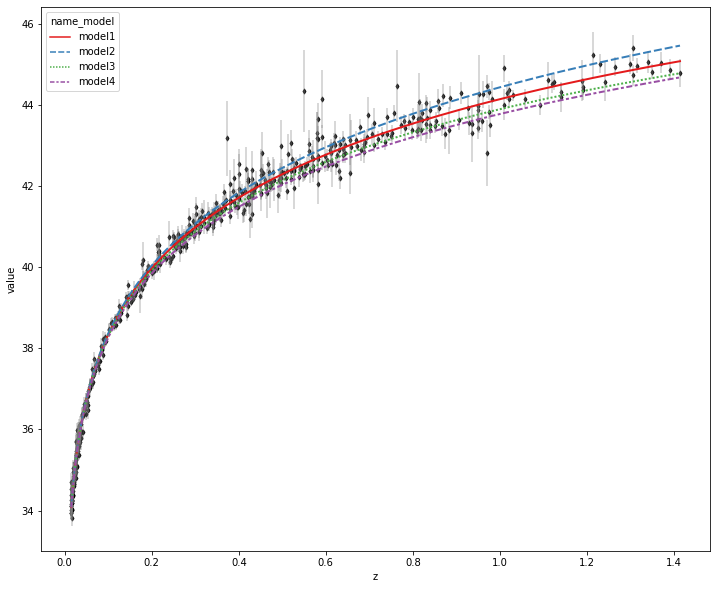

In [24]:
#Grafica del ajuste de los modelos
df2 = df.copy()
df2=pd.melt(df2, id_vars = ['name','z','dl_real' ,'dl_real_error','d3'], var_name = 'name_model', value_name = 'value')

plt.figure(figsize = (12,10))
plt.scatter(df['z'],df['dl_real'], alpha=0.85, marker='d', s = 12, c='k')
plt.errorbar(df['z'],df['dl_real'],yerr=df['dl_real_error'], linestyle="None", alpha=0.4, c='gray')
sns.lineplot(data=df2, x="z", y="value", hue="name_model", palette='Set1', style="name_model", linewidth = 2)


# Bibliografía

1. Supernova Cosmology Project https://supernova.lbl.gov/Union/

2. Grafico https://supernova.lbl.gov/Union/figures/Union2.1_Hubble_slide.pdf

3. Datos https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt